In [1]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import logging
from concurrent.futures import ThreadPoolExecutor

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader as TorchDataLoader
from torch.utils.data import WeightedRandomSampler
import kornia
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns  # For confusion matrix heatmap

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------- Data Augmentation (TorchVision) ----------------------------
# We'll define data transforms for training (with augmentation) and for validation/test (no augmentation).
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # ±20%
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---------------------------- DataLoader ----------------------------
class FingerprintDataset(Dataset):
    """
    This Dataset holds (image, label) pairs and applies either the train_transform
    or eval_transform depending on whether it's for training or not.
    """
    def __init__(self, images, labels, is_train=True):
        self.images = images
        self.labels = labels
        self.is_train = is_train
        # We'll store the transform references
        self.transform = train_transform if is_train else eval_transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        # Apply transform (augmentation if training)
        img_t = self.transform(img)
        return img_t, lbl

class DataLoaderCustom:
    """
    Loads the data from the specified directories, producing images and labels in memory.
    We'll then create PyTorch Datasets from those.
    """
    def __init__(self, dataset_dirs, num_threads=8):
        self.dataset_dirs = dataset_dirs
        self.num_threads = num_threads

    def load_dataset(self):
        images = []
        labels = []
        with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
            futures = [executor.submit(self._process_dataset_dir, dataset_dir)
                       for dataset_dir in self.dataset_dirs]
            for future in futures:
                sub_images, sub_labels = future.result()
                images.extend(sub_images)
                labels.extend(sub_labels)
        return images, labels

    def extract_label_from_filename(self, filename):
        lower_file = filename.lower()
        for finger in ["thumb", "index", "middle", "ring", "little"]:
            if finger in lower_file:
                return finger.capitalize()
        return None

    def _process_dataset_dir(self, dataset_dir):
        local_images = []
        local_labels = []
        print(f"Processing dataset directory: {dataset_dir}")
        entries = os.listdir(dataset_dir)
        entries = [entry for entry in entries if entry.lower() != 'thumbs.db']
        if all(not os.path.isdir(os.path.join(dataset_dir, entry)) for entry in entries):
            for file in entries:
                if file.lower().endswith(('.tif', '.bpm', '.bmp', '.png', '.jpeg', '.jpg')):
                    file_path = os.path.join(dataset_dir, file)
                    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                    if img is not None:
                        label_extracted = self.extract_label_from_filename(file)
                        if label_extracted is None:
                            label_extracted = os.path.basename(dataset_dir)
                        local_images.append(img)
                        local_labels.append(label_extracted)
                        print(f"  Loaded image: {file} with label: {label_extracted}")
                    else:
                        print(f"  Failed to load image: {file}")
        else:
            for label in entries:
                label_path = os.path.join(dataset_dir, label)
                if os.path.isdir(label_path):
                    seen_files = set()
                    for file in os.listdir(label_path):
                        if file.lower().endswith(('.tif', '.bpm', '.bmp', '.png', '.jpeg', '.jpg')):
                            file_path = os.path.join(label_path, file)
                            file_size = os.path.getsize(file_path)
                            if file_size in seen_files:
                                continue
                            seen_files.add(file_size)
                            img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                            if img is not None:
                                local_images.append(img)
                                local_labels.append(label)
                                print(f"  Loaded image: {file} with label: {label}")
                            else:
                                print(f"  Failed to load image: {file}")
                else:
                    print(f"  Skipping non-directory entry: {label}")
        return local_images, local_labels

# ---------------------------- FeatureExtractor ----------------------------
class FeatureExtractor:
    """
    Full ResNet is unfrozen: we will not simply 'eval()' everything.
    Instead, we'll define the model and allow training on it. But for
    the sake of your pipeline, we still generate classical features (mean, std).
    
    However, to incorporate data augmentation and fine-tuning,
    we'll do the deep features inside the new 'CombinedModel' class instead.
    
    That said, we'll keep this class for GPU-based edge detection if needed.
    """
    def __init__(self):
        # We won't do the final transform/resizing here, because we do that in the Dataset transforms.
        # But we still need the classical edge extraction logic (kornia).
        pass

    def gpu_preprocess_image(self, img_tensor):
        """
        Expects a normalized 3-channel tensor on GPU [1,3,H,W],
        then converts to grayscale, blur, sobel edge detection, returns edge map.
        """
        gray = kornia.color.rgb_to_grayscale(img_tensor)
        blurred = kornia.filters.gaussian_blur2d(gray, kernel_size=(5, 5), sigma=(1.0, 1.0))
        edges = kornia.filters.sobel(blurred)
        edge_map = torch.sqrt(torch.sum(edges ** 2, dim=1, keepdim=True))
        return edge_map

    def extract_fingerprint_features(self, edge_map):
        mean_edge = torch.mean(edge_map)
        std_edge = torch.std(edge_map)
        return mean_edge.item(), std_edge.item()

# ---------------------------- CombinedModel: Fine-Tuning ResNet + Classical Edge Features ----------------------------
class CombinedModel(nn.Module):
    """
    A model that:
      1) Accepts an augmented input image (already resized/normalized),
      2) Runs it through an unfrozen ResNet50 to get a 2048-dim feature,
      3) Extracts classical (mean, std) from an edge map,
      4) Concatenates the 2048 deep features + 2 classical features -> 2050,
      5) Passes them to a small MLP for classification.
    """
    def __init__(self, num_classes=5):
        super(CombinedModel, self).__init__()
        # Load pretrained ResNet50, unfreeze all layers
        base_resnet = models.resnet50(pretrained=True)
        for param in base_resnet.parameters():
            param.requires_grad = True  # Unfreeze everything

        # Remove final FC layer
        self.resnet_backbone = nn.Sequential(*list(base_resnet.children())[:-1])
        # We'll get a (batch_size, 2048, 1, 1) feature from this

        # MLP classifier on top of 2050-dim features
        self.classifier = nn.Sequential(
            nn.Linear(2050, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        self.feature_extractor = FeatureExtractor()  # for classical edges

    def forward(self, x):
        """
        x: [batch_size, 3, H, W] (already augmented & normalized)
        """
        # 1) Extract deep features
        deep_feat = self.resnet_backbone(x)  # shape = [B, 2048, 1, 1]
        deep_feat = deep_feat.view(deep_feat.size(0), -1)  # [B, 2048]

        # 2) Extract classical edge-based features
        #    We'll do GPU-based edge detection. Need x to be on GPU, shape [B, 3, H, W].
        edge_map = self.feature_extractor.gpu_preprocess_image(x)
        # shape of edge_map = [B, 1, H, W]
        # compute mean & std along dims (1,2,3)
        # Alternatively, do it for each image in a loop, but we can do it vectorized:
        mean_edge = edge_map.view(edge_map.size(0), -1).mean(dim=1)  # [B]
        std_edge = edge_map.view(edge_map.size(0), -1).std(dim=1)    # [B]

        # 3) Concatenate
        classical_feats = torch.stack([mean_edge, std_edge], dim=1)  # [B, 2]
        fused = torch.cat([deep_feat, classical_feats], dim=1)       # [B, 2050]

        # 4) Classify
        logits = self.classifier(fused)
        return logits

# ---------------------------- Oversampling Logic ----------------------------
def make_weighted_sampler(labels):
    """
    Creates a WeightedRandomSampler to oversample "Ring" and "Middle".
    We'll compute class frequencies and invert them to get weights.
    """
    from collections import Counter
    freq = Counter(labels)  # e.g. {'Thumb': 1200, 'Index':1000, 'Ring':700, 'Middle':700, 'Little':900}
    total = len(labels)
    # weight for each class = total / freq[class]
    class_weights = {cls: total / freq[cls] for cls in freq}

    # Build a weight array for each sample
    sample_weights = [class_weights[lbl] for lbl in labels]
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples=len(labels),
                                    replacement=True)
    return sampler

# ---------------------------- Model Trainer ----------------------------
class ModelTrainer:
    def __init__(self, num_classes=5, num_epochs=40, lr=1e-4, batch_size=32):
        self.num_classes = num_classes
        self.num_epochs = num_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.model = CombinedModel(num_classes=num_classes).to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.label_to_idx = {}
        self.idx_to_label = {}

    def fit(self, train_images, train_labels, val_images, val_labels):
        """
        Create Datasets & DataLoaders, oversample ring/middle in train, run training for self.num_epochs.
        """
        # Label encoding
        unique_labels = sorted(list(set(train_labels)))
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}

        # Convert textual labels to integer indices
        train_numeric_labels = [self.label_to_idx[lbl] for lbl in train_labels]
        val_numeric_labels   = [self.label_to_idx[lbl] for lbl in val_labels]

        # Build Datasets
        train_dataset = FingerprintDataset(train_images, train_labels, is_train=True)
        val_dataset   = FingerprintDataset(val_images,   val_labels,   is_train=False)

        # Weighted sampler for ring & middle oversampling in train
        train_sampler = make_weighted_sampler(train_labels)

        # DataLoaders
        train_loader = TorchDataLoader(train_dataset, batch_size=self.batch_size,
                                       sampler=train_sampler, drop_last=False)
        val_loader = TorchDataLoader(val_dataset, batch_size=self.batch_size,
                                     shuffle=False, drop_last=False)

        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0
            total_samples = 0
            for batch_x, batch_labels_str in train_loader:
                # Convert textual labels to numeric
                batch_labels = torch.tensor([self.label_to_idx[lbl] for lbl in batch_labels_str],
                                            dtype=torch.long)
                batch_x = batch_x.to(device)
                batch_labels = batch_labels.to(device)

                self.optimizer.zero_grad()
                logits = self.model(batch_x)
                loss = self.criterion(logits, batch_labels)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * batch_x.size(0)
                total_samples += batch_x.size(0)

            avg_loss = total_loss / total_samples
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {avg_loss:.4f}")

            # Optional: you could evaluate on val_loader each epoch if you like.

        print("Training complete.")

    def evaluate(self, test_images, test_labels):
        """
        Evaluate on test set, printing accuracy & weighted F1.
        """
        test_dataset = FingerprintDataset(test_images, test_labels, is_train=False)
        test_loader = TorchDataLoader(test_dataset, batch_size=self.batch_size,
                                      shuffle=False, drop_last=False)

        self.model.eval()
        all_preds = []
        all_truth = []
        with torch.no_grad():
            for batch_x, batch_labels_str in test_loader:
                batch_x = batch_x.to(device)
                logits = self.model(batch_x)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_truth.extend([lbl for lbl in batch_labels_str])

        # Convert numeric preds back to string labels
        pred_labels_str = [self.idx_to_label[p] for p in all_preds]

        # Accuracy
        acc = accuracy_score(all_truth, pred_labels_str)
        f1 = f1_score(all_truth, pred_labels_str, average='weighted', zero_division=0)
        print(f"Test Accuracy: {acc:.2f}")
        print(f"Test F1 Score: {f1:.2f}")

        return pred_labels_str

    def predict(self, images_list):
        """
        For e.g. single-image or small batch inference: returns predicted textual labels
        and raw logits. The input is a list of images or a single image in a list.
        """
        self.model.eval()
        # We create a small dataset for images_list with is_train=False
        dummy_labels = ["Unknown"] * len(images_list)  # placeholder
        dummy_dataset = FingerprintDataset(images_list, dummy_labels, is_train=False)
        dummy_loader = TorchDataLoader(dummy_dataset, batch_size=len(images_list),
                                       shuffle=False, drop_last=False)

        with torch.no_grad():
            for batch_x, _ in dummy_loader:
                batch_x = batch_x.to(device)
                logits = self.model(batch_x)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                # Convert to textual labels
                pred_labels_str = [self.idx_to_label[p] for p in preds]
                return pred_labels_str, logits.cpu().numpy()

# ---------------------------- Pipeline ----------------------------
class Pipeline:
    def __init__(self, dataset_dirs, num_epochs=40, lr=1e-4, batch_size=32):
        self.dataset_dirs = dataset_dirs
        self.num_epochs = num_epochs
        self.lr = lr
        self.batch_size = batch_size

        self.data_loader = DataLoaderCustom(dataset_dirs)
        self.model_trainer = None

        self.y_train = []
        self.y_val = []
        self.y_test = []
        self.train_imgs = []
        self.val_imgs = []
        self.test_imgs = []

    def run(self):
        # 1) Load images & labels
        images, labels = self.data_loader.load_dataset()
        print(f"Loaded {len(images)} images total.")

        # 2) Train-val-test split
        X_temp, X_test, y_temp, y_test = train_test_split(images, labels,
                                                          test_size=0.15, random_state=42, stratify=labels)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                          test_size=0.1765, random_state=42, stratify=y_temp)

        self.train_imgs = X_train
        self.val_imgs   = X_val
        self.test_imgs  = X_test

        self.y_train = y_train
        self.y_val   = y_val
        self.y_test  = y_test

        print(f"Training set: {len(X_train)} images, Validation set: {len(X_val)} images, Test set: {len(X_test)} images")

        # 3) Build and train the combined model
        self.model_trainer = ModelTrainer(num_classes=len(set(y_train)),
                                          num_epochs=self.num_epochs,
                                          lr=self.lr,
                                          batch_size=self.batch_size)
        self.model_trainer.fit(X_train, y_train, X_val, y_val)

        # 4) Evaluate on test
        self.model_trainer.evaluate(X_test, y_test)

# ---------------------------- Visualization & Inference ----------------------------
def plot_class_distribution(y_train, y_val, y_test, save_path='class_distribution.png'):
    classes = sorted(list(set(y_train + y_val + y_test)))
    train_counts = [y_train.count(cls) for cls in classes]
    val_counts   = [y_val.count(cls)   for cls in classes]
    test_counts  = [y_test.count(cls)  for cls in classes]

    x = np.arange(len(classes))
    width = 0.25

    plt.figure(figsize=(8, 6))
    plt.bar(x - width, train_counts, width, label='Train')
    plt.bar(x,         val_counts,   width, label='Validation')
    plt.bar(x + width, test_counts,  width, label='Test')

    plt.xlabel('Finger Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution: Train / Validation / Test')
    plt.xticks(x, classes)
    plt.legend()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_and_report(pipeline, normalize=None, save_path='confusion_matrix.png'):
    test_imgs = pipeline.test_imgs
    test_labels = pipeline.y_test
    trainer = pipeline.model_trainer

    # We'll use the .evaluate() method's approach but gather predictions for the entire test set
    test_dataset = FingerprintDataset(test_imgs, test_labels, is_train=False)
    test_loader = TorchDataLoader(test_dataset, batch_size=trainer.batch_size,
                                  shuffle=False, drop_last=False)

    trainer.model.eval()
    all_preds = []
    all_truth = []
    with torch.no_grad():
        for batch_x, batch_labels_str in test_loader:
            batch_x = batch_x.to(device)
            logits = trainer.model(batch_x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_truth.extend(batch_labels_str)

    class_labels = sorted(list(trainer.label_to_idx.keys()))
    # Convert numeric preds to textual labels
    pred_labels_str = [trainer.idx_to_label[p] for p in all_preds]

    cm = confusion_matrix(all_truth, pred_labels_str, labels=class_labels, normalize=normalize)
    print("\nClassification Report:")
    print(classification_report(all_truth, pred_labels_str, labels=class_labels))

    plt.figure(figsize=(8, 6))
    fmt = '.2f' if normalize else 'd'
    sns.heatmap(cm, annot=True, fmt=fmt,
                xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    title_str = "Confusion Matrix"
    if normalize:
        title_str += f" (Normalized: {normalize})"
    plt.title(title_str)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

def single_image_inference_with_visuals(pipeline, image_path):
    """
    Loads a single image, extracts features using the pipeline's feature extractor,
    applies the pipeline's feature mask (if any), predicts the label,
    AND displays the original vs. processed image side by side.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image from {image_path}")
        return None, None
    
    # (1) Extract fused features, plus the edge map (processed_img) and fingerprint features
    #    Note: process_single_image returns (fused_feat, edge_map, fingerprint_feat)
    fused_feat, edge_map, fingerprint_feat = pipeline.feature_extractor.process_single_image(img)
    
    # (2) Display side-by-side images: Original vs. Edge Map
    plt.figure(figsize=(10, 5))
    # Left subplot: Original (in RGB format)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    # Right subplot: Edge Map (grayscale)
    plt.subplot(1, 2, 2)
    plt.imshow(edge_map, cmap="gray")
    plt.title("Processed (Edge Map)")
    plt.axis("off")

    plt.show()

    # (3) Apply feature mask (if any)
    if pipeline.best_feature_mask is not None:
        fused_feat = fused_feat[pipeline.best_feature_mask]

    # (4) Model inference
    X_input = np.array([fused_feat])
    pipeline.model_trainer.model.eval()

    with torch.no_grad():
        X_tensor = torch.tensor(X_input, dtype=torch.float32).to(pipeline.model_trainer.model.fc[0].weight.device)
        logits = pipeline.model_trainer.model(X_tensor)
        softmax_probs = torch.nn.functional.softmax(logits, dim=1)
    
    _, predicted_indices = torch.max(softmax_probs, dim=1)
    predicted_index = predicted_indices[0].item()
    predicted_label = pipeline.model_trainer.idx_to_label[predicted_index]
    
    # (5) Print probabilities
    probs_np = softmax_probs[0].cpu().numpy()
    class_labels = [pipeline.model_trainer.idx_to_label[i] for i in range(len(probs_np))]
    probabilities = {label: float(prob) for label, prob in zip(class_labels, probs_np)}

    print(f"Predicted Label: {predicted_label}")
    print("Probabilities:")
    for cls, prob in probabilities.items():
        print(f"  {cls}: {prob:.4f}")

    return predicted_label, probabilities

# ---------------------------- Example Usage ----------------------------
if __name__ == "__main__":
    dataset_dirs = [
        os.path.expanduser("~/data/SOCOFing/Real")
    ]

    # Create Pipeline (no feature selection, unfreezing ResNet, 20 epochs)
    pipeline = Pipeline(dataset_dirs, num_epochs=40, lr=1e-4, batch_size=32)
    pipeline.run()



Using device: cuda:0
Processing dataset directory: /home/zaman-m65/data/SOCOFing/Real
  Loaded image: 134__M_Left_little_finger.BMP with label: Little
  Loaded image: 456__M_Right_little_finger.BMP with label: Little
  Loaded image: 103__F_Right_thumb_finger.BMP with label: Thumb
  Loaded image: 293__F_Left_middle_finger.BMP with label: Middle
  Loaded image: 110__F_Left_little_finger.BMP with label: Little
  Loaded image: 80__M_Left_middle_finger.BMP with label: Middle
  Loaded image: 574__F_Right_ring_finger.BMP with label: Ring
  Loaded image: 546__M_Left_index_finger.BMP with label: Index
  Loaded image: 237__M_Right_little_finger.BMP with label: Little
  Loaded image: 8__M_Right_ring_finger.BMP with label: Ring
  Loaded image: 533__M_Right_little_finger.BMP with label: Little
  Loaded image: 106__M_Left_ring_finger.BMP with label: Ring
  Loaded image: 474__M_Left_ring_finger.BMP with label: Ring
  Loaded image: 289__F_Left_middle_finger.BMP with label: Middle
  Loaded image: 176__

/home/zaman-m65/miniconda3/envs/my_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zaman-m65/miniconda3/envs/my_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/40], Loss: 1.0655
Epoch [2/40], Loss: 0.8175
Epoch [3/40], Loss: 0.7436
Epoch [4/40], Loss: 0.7050
Epoch [5/40], Loss: 0.6475
Epoch [6/40], Loss: 0.6154
Epoch [7/40], Loss: 0.5905
Epoch [8/40], Loss: 0.5355
Epoch [9/40], Loss: 0.5248
Epoch [10/40], Loss: 0.4786
Epoch [11/40], Loss: 0.4388
Epoch [12/40], Loss: 0.4537
Epoch [13/40], Loss: 0.4371
Epoch [14/40], Loss: 0.4023
Epoch [15/40], Loss: 0.3647
Epoch [16/40], Loss: 0.3508
Epoch [17/40], Loss: 0.3395
Epoch [18/40], Loss: 0.3259
Epoch [19/40], Loss: 0.3248
Epoch [20/40], Loss: 0.3003
Epoch [21/40], Loss: 0.2685
Epoch [22/40], Loss: 0.2716
Epoch [23/40], Loss: 0.2801
Epoch [24/40], Loss: 0.2695
Epoch [25/40], Loss: 0.2412
Epoch [26/40], Loss: 0.2196
Epoch [27/40], Loss: 0.2286
Epoch [28/40], Loss: 0.2033
Epoch [29/40], Loss: 0.1951
Epoch [30/40], Loss: 0.1857
Epoch [31/40], Loss: 0.1855
Epoch [32/40], Loss: 0.2095
Epoch [33/40], Loss: 0.1646
Epoch [34/40], Loss: 0.1880
Epoch [35/40], Loss: 0.1595
Epoch [36/40], Loss: 0.1895
E

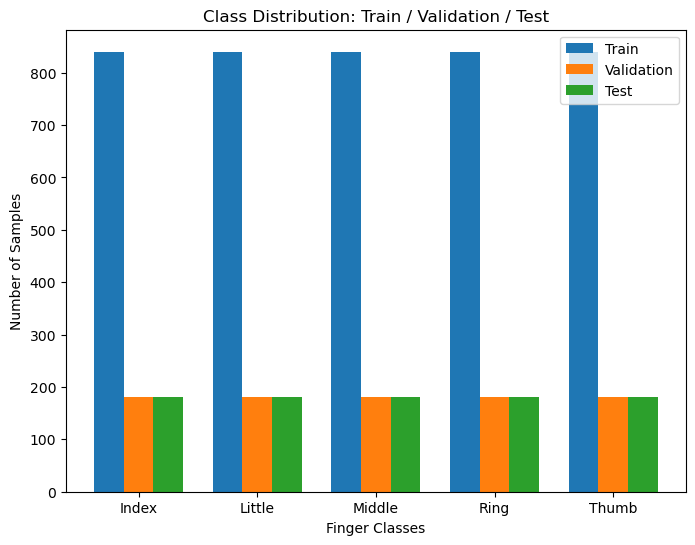

In [2]:
  # Plot class distribution
plot_class_distribution(pipeline.y_train, pipeline.y_val, pipeline.y_test)


Classification Report:
              precision    recall  f1-score   support

       Index       0.78      0.85      0.81       180
      Little       0.78      0.79      0.79       180
      Middle       0.72      0.66      0.69       180
        Ring       0.65      0.67      0.66       180
       Thumb       0.96      0.91      0.93       180

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900



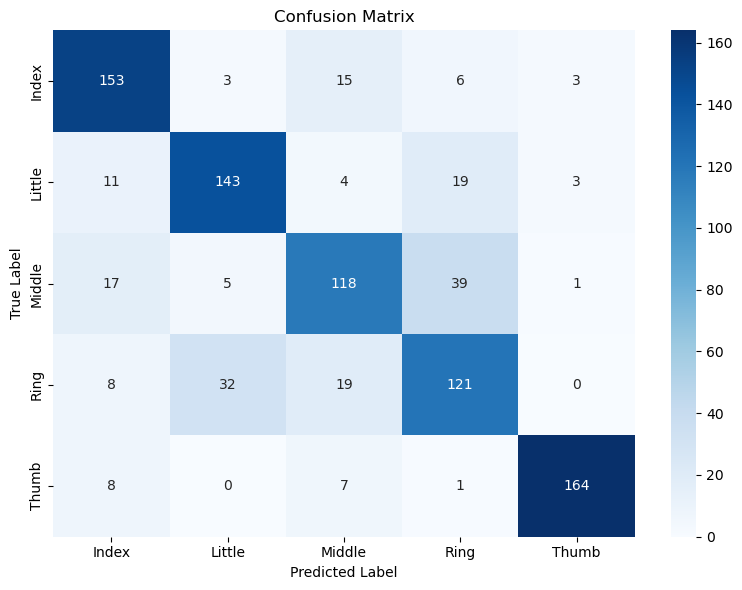

In [3]:
 # Confusion matrix & classification report
plot_confusion_matrix_and_report(pipeline, normalize=None, save_path='confusion_matrix.png')

In [5]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import kornia                      # already installed
from torchvision import transforms # reuse the eval_transform

# ──────────────────────────────────────────────────────────────────────────
def single_image_inference_with_visuals(pipeline, image_path):
    """
    • Shows original ↔︎ edge‑map side‑by‑side.
    • Runs the EfficientNet‑edge model and prints class probabilities.
    Works with the CURRENT pipeline (no external feature_extractor).
    """
    # ------------------------------------------------ load image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"❌  Could not read image: {image_path}")
        return None, None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # ------------------------------------------------ build edge map for display
    img_t_edge = transforms.ToTensor()(cv2.resize(img_rgb, (224, 224))).unsqueeze(0).to(device)
    gray       = kornia.color.rgb_to_grayscale(img_t_edge)
    blur       = kornia.filters.gaussian_blur2d(gray, (5,5), (1.0,1.0))
    sobel      = kornia.filters.sobel(blur)
    edge_map   = torch.sqrt((sobel**2).sum(dim=1, keepdim=True))[0,0].cpu().numpy()

    # ------------------------------------------------ model inference
    input_tensor = eval_transform(img_rgb).unsqueeze(0).to(device)   # [1,3,224,224]
    trainer      = pipeline.model_trainer
    trainer.model.eval()
    with torch.no_grad():
        logits = trainer.model(input_tensor)                         # [1,num_classes]
        probs  = torch.softmax(logits, dim=1)[0].cpu().numpy()       # [num_classes]

    idx          = int(probs.argmax())
    pred_label   = trainer.idx_to_label[idx]
    class_labels = [trainer.idx_to_label[i] for i in range(len(probs))]
    prob_dict    = {lbl: float(p) for lbl, p in zip(class_labels, probs)}

    # ------------------------------------------------ side‑by‑side display
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(img_rgb);  plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(edge_map, cmap="gray"); plt.title("Edge map"); plt.axis("off")
    plt.suptitle(f"Predicted: {pred_label}", fontsize=14)
    plt.show()

    # ------------------------------------------------ console print‑out
    print("Probabilities:")
    for cls, pr in prob_dict.items():
        print(f"  {cls:<7}: {pr:.4f}")

    return pred_label, prob_dict
# ──────────────────────────────────────────────────────────────────────────


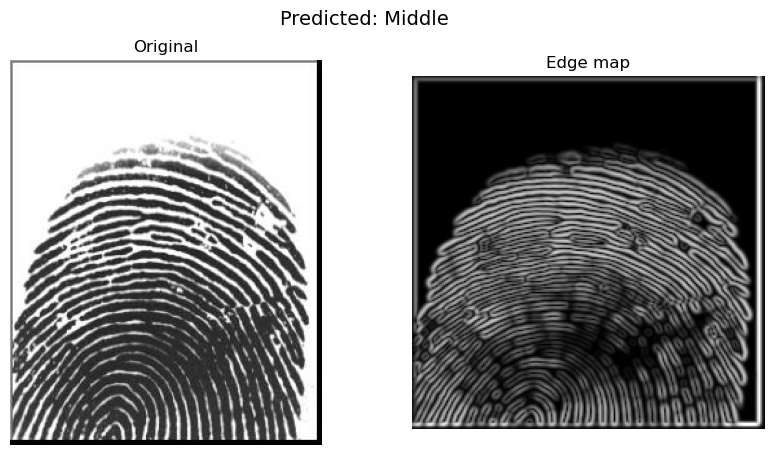

Probabilities:
  Index  : 0.0000
  Little : 0.0006
  Middle : 0.9445
  Ring   : 0.0549
  Thumb  : 0.0000
Predicted label = Middle
Probabilities  = {'Index': 3.676755295600742e-05, 'Little': 0.0005531118949875236, 'Middle': 0.9445449709892273, 'Ring': 0.054856859147548676, 'Thumb': 8.294665349239949e-06}


In [6]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/270__M_Left_ring_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


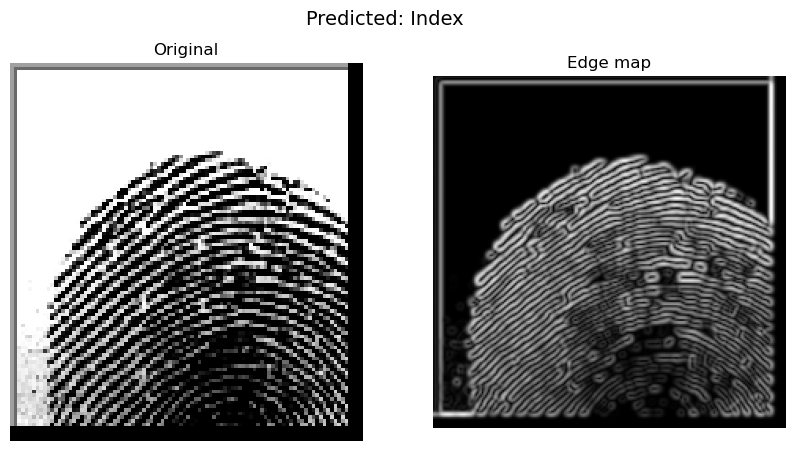

Probabilities:
  Index  : 0.8804
  Little : 0.0000
  Middle : 0.1188
  Ring   : 0.0006
  Thumb  : 0.0002
Predicted label = Index
Probabilities  = {'Index': 0.8803615570068359, 'Little': 4.0347575122723356e-05, 'Middle': 0.1187717616558075, 'Ring': 0.0006488881190307438, 'Thumb': 0.00017750512051861733}


In [7]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/281__M_Left_index_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


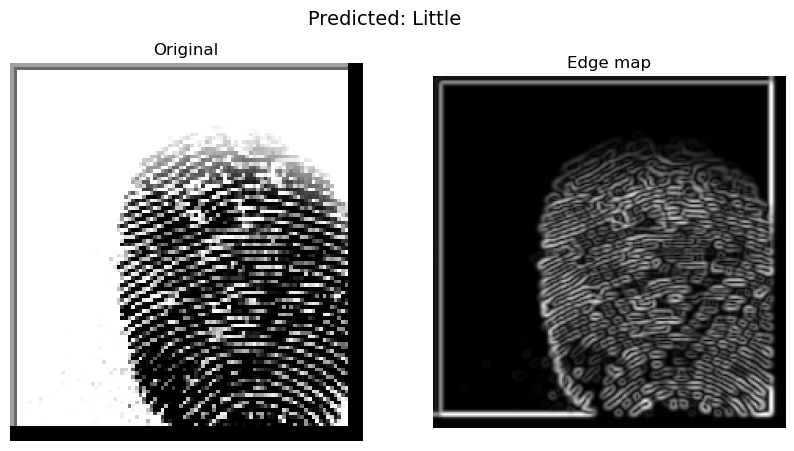

Probabilities:
  Index  : 0.0000
  Little : 0.9998
  Middle : 0.0000
  Ring   : 0.0002
  Thumb  : 0.0000
Predicted label = Little
Probabilities  = {'Index': 2.7440009944257326e-05, 'Little': 0.9998199343681335, 'Middle': 3.290734866823186e-07, 'Ring': 0.00015141829499043524, 'Thumb': 8.967686540017894e-07}


In [8]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/45__M_Right_little_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


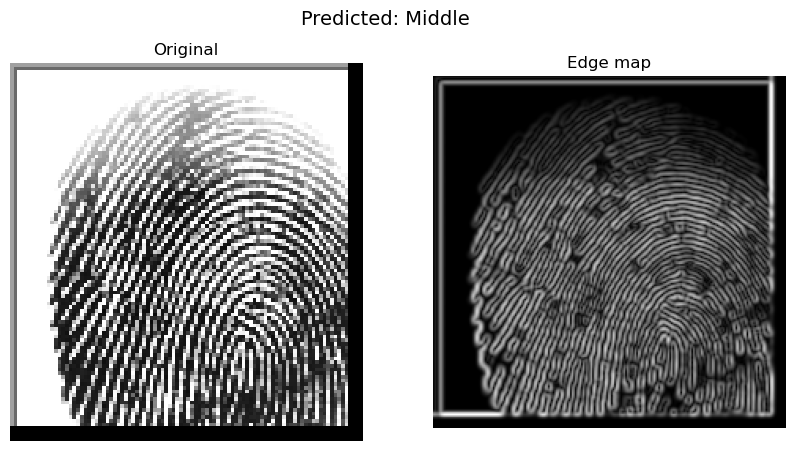

Probabilities:
  Index  : 0.0007
  Little : 0.0115
  Middle : 0.9212
  Ring   : 0.0667
  Thumb  : 0.0000
Predicted label = Middle
Probabilities  = {'Index': 0.0006584083312191069, 'Little': 0.011470264755189419, 'Middle': 0.9211863279342651, 'Ring': 0.06668294221162796, 'Thumb': 2.0989675704186084e-06}


In [9]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/279__M_Left_middle_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


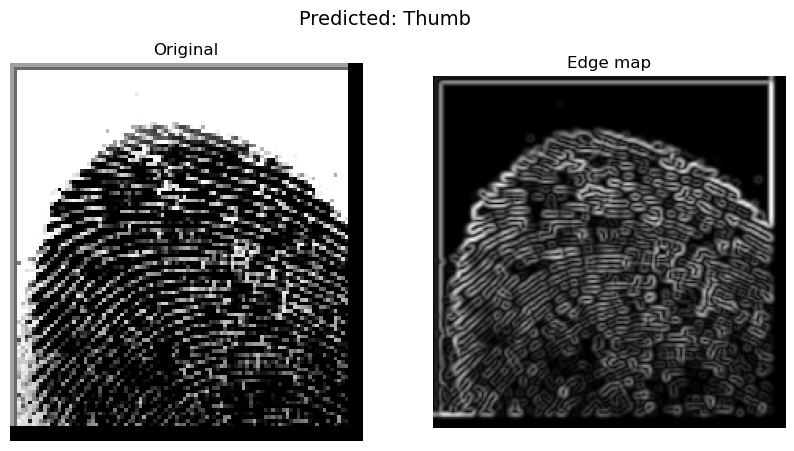

Probabilities:
  Index  : 0.0001
  Little : 0.0000
  Middle : 0.0000
  Ring   : 0.0000
  Thumb  : 0.9998
Predicted label = Thumb
Probabilities  = {'Index': 0.00012247155245859176, 'Little': 5.036017114434799e-08, 'Middle': 4.252782673574984e-05, 'Ring': 2.127491643477697e-05, 'Thumb': 0.9998136162757874}


In [10]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/27__M_Right_thumb_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


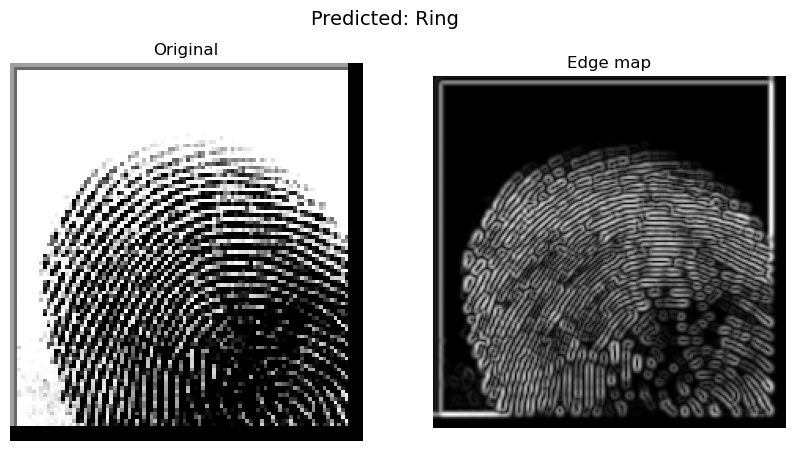

Probabilities:
  Index  : 0.0000
  Little : 0.0142
  Middle : 0.0005
  Ring   : 0.9853
  Thumb  : 0.0000
Predicted label = Ring
Probabilities  = {'Index': 5.244443855190184e-06, 'Little': 0.014185599982738495, 'Middle': 0.0005410422454588115, 'Ring': 0.9852676391601562, 'Thumb': 4.954897008246917e-07}


In [11]:
test_img = os.path.expanduser(
    "~/data/SOCOFing/Real/98__M_Right_ring_finger.BMP")

label, probs = single_image_inference_with_visuals(pipeline, test_img)

print("Predicted label =", label)        # show the label in console
print("Probabilities  =", probs)         # full probability dict


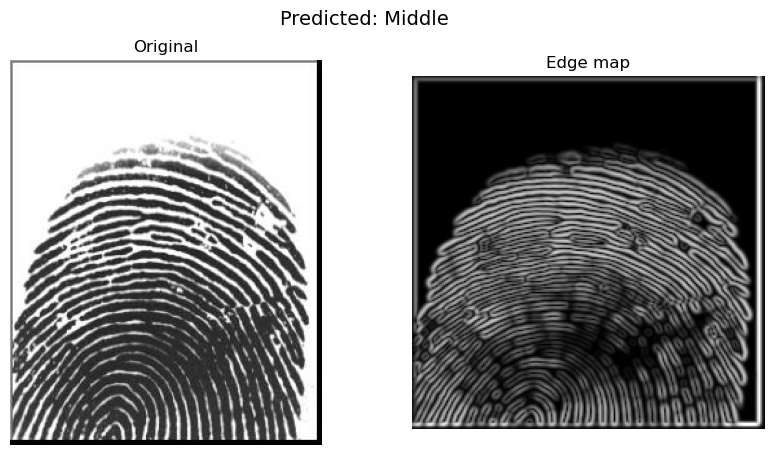

Probabilities:
  Index  : 0.0000
  Little : 0.0006
  Middle : 0.9445
  Ring   : 0.0549
  Thumb  : 0.0000


In [12]:
test_img = os.path.expanduser("~/data/SOCOFing/Real/270__M_Left_ring_finger.BMP")
pred, probs = single_image_inference_with_visuals(pipeline, test_img)